# Network distance tying it all together
Here, we will calculate the walking distance for students in public schools to their nearest subway entrance.

In [68]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import box, LineString, Point,MultiPoint
import os
import sys
from scipy.spatial import cKDTree
import numpy as np
from zipfile import ZipFile as zzip
import requests
from rtree import index
import rtree
import itertools
from shapely import wkt
from shapely.ops import split, snap

sys.path.append(os.path.realpath('..'))

In [6]:
os.getcwd()

'C:\\Work\\Box Sync\\GIS_exploration\\code'

## Get the 2019 "NYC LION Single Line Street Base Map"

In [29]:
url = r"https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyclion_19b.zip"
filename = r"nyclion_19b.zip"
r = requests.get(url)
# open method to open a file on your system and write the contents
with open("../input_data/"+filename, "wb") as file:
    file.write(r.content)

In [30]:
fp = "../input_data/"
foldername = "nyclion_19b"
with zzip(fp+filename, 'r') as file: 
        #printing all the contents of the zip file 
        #file.printdir() 
        path = "../input_data/"+foldername
        os.mkdir(path)
        # extracting all the files 
        print('Extracting all the files now...') 
        file.extractall(fp+foldername) 
        print('Done!')

File Name                                             Modified             Size
lion/lion.gdb/a00000001.freelist               2019-05-13 12:48:56         4440
lion/lion.gdb/a00000001.gdbindexes             2019-05-13 12:42:56          110
lion/lion.gdb/a00000001.gdbtable               2019-05-13 12:48:56          385
lion/lion.gdb/a00000001.gdbtablx               2019-05-13 12:48:56         5152
lion/lion.gdb/a00000001.TablesByName.atx       2019-05-13 12:48:56         4118
lion/lion.gdb/a00000002.gdbtable               2019-05-13 12:42:56         2055
lion/lion.gdb/a00000002.gdbtablx               2019-05-13 12:42:56         5152
lion/lion.gdb/a00000003.gdbindexes             2019-05-13 12:42:56           42
lion/lion.gdb/a00000003.gdbtable               2019-05-13 12:44:22         1825
lion/lion.gdb/a00000003.gdbtablx               2019-05-13 12:44:22         5152
lion/lion.gdb/a00000004.CatItemsByPhysicalName.atx 2019-05-13 12:48:56         4118
lion/lion.gdb/a00000004.CatItemsByTy

Reading the lion layer into a geopandas dataframe

In [31]:
fp = "../input_data/nyclion_19b/lion/lion.gdb"
lion_gdf = gpd.read_file(fp, driver='FileGDB', layer='lion')

Removing the non pedestrian accessible roads/paths

In [32]:
lion_gdf['todrop'] = (lion_gdf['NonPed'] == 'V') |(lion_gdf['FeatureTyp'].isin(['F','9','1','7','3'])) |(lion_gdf['TrafDir'].isin([' ']))

In [33]:
lion_gdf = lion_gdf.loc[lion_gdf['todrop'] == False]

In [34]:
lion_gdf.crs

{'init': 'epsg:2263'}

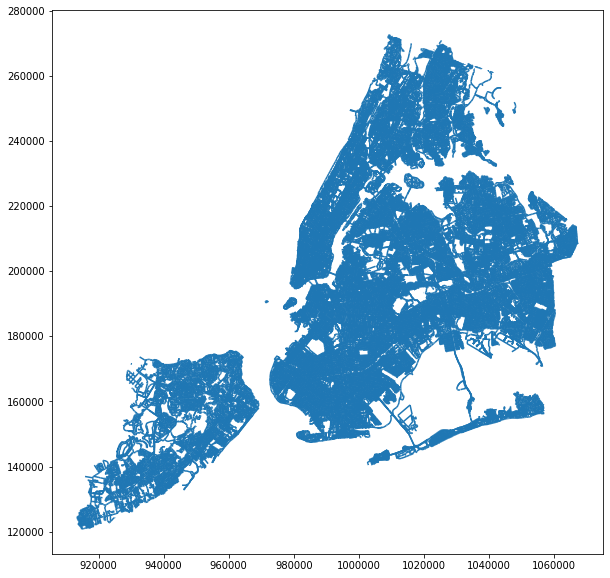

In [41]:
lion_gdf.plot(figsize = (10,10), markersize = 1);

In [46]:
lion_gdf.head()

,Street,SAFStreetName,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,SpecAddr,...,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,SHAPE_Length,geometry,todrop
0,EAST 168 STREET,,0,U,,B,,T,DOT,,...,596,716,599,699,596,716,2251001000000,396.030947,(LINESTRING (1010964.446978778 241812.26140345...,False
1,WEST 192 STREET,,0,U,,B,,A,DOT,,...,63,99,58,98,63,99,2798401000000,279.360514,(LINESTRING (1011576.686607853 255023.58303095...,False
2,UNION AVENUE,,0,U,,B,,W,DOT,,...,1016,1084,1017,1079,1016,1084,2728001000000,618.327133,(LINESTRING (1011600.676209003 239639.74280026...,False
3,UNION AVENUE,BEHAGEN PLAYGROUND,0,U,,B,,W,DOT,N,...,None,None,0,0,0,0,21279501000000N,618.327133,(LINESTRING (1011600.676209003 239639.74280026...,False
4,DELAFIELD AVENUE,,6,U,,B,,T,DOT,,...,4600,4664,4601,4645,4600,4664,2187601000000,670.281037,(LINESTRING (1009974.212831751 264857.13919802...,False


In [54]:
fp = r"../intermediate_data/nyclion_19b/"
os.mkdir(fp)
lion_gdf[['geometry']].to_file(fp+"nyclion_19b.shp")

## Getting the public school location data from NYC Open Data

In [19]:
url = r"https://data.cityofnewyork.us/download/jfju-ynrr/application%2Fzip"
filename = r"Public_School_Locations.zip"
r = requests.get(url)
# open method to open a file on your system and write the contents
with open("../input_data/"+filename, "wb") as file:
    file.write(r.content)

In [23]:
fp = "../input_data/"
foldername = "Public_School_Locations"
with zzip(fp+filename, 'r') as file: 
        # printing all the contents of the zip file 
        file.printdir() 
        path = "../input_data/"+foldername
        os.mkdir(path)
        # extracting all the files 
        print('Extracting all the files now...') 
        file.extractall(fp+foldername) 
        print('Done!')

File Name                                             Modified             Size
Public_Schools_Points_2011-2012A.dbf           2011-08-26 10:30:16       771337
Public_Schools_Points_2011-2012A.prj           2010-10-12 11:55:12          562
Public_Schools_Points_2011-2012A.sbn           2011-08-03 11:23:00        16580
Public_Schools_Points_2011-2012A.sbx           2011-08-03 11:23:00          868
Public_Schools_Points_2011-2012A.shp           2011-08-03 11:23:00        47952
Public_Schools_Points_2011-2012A.shp.xml       2011-08-26 10:32:50        28413
Public_Schools_Points_2011-2012A.shx           2011-08-03 11:23:00        13772
Extracting all the files now...
Done!


Read the school point shapefile into a geopandas geodataframe

In [25]:
fp = "../input_data/Public_School_Locations/Public_Schools_Points_2011-2012A.shp"
schools = gpd.read_file(fp)

In [26]:
schools.crs

{'init': 'epsg:2263'}

In [42]:
schools.head()

,ATS_CODE,BORO,BORONUM,LOC_CODE,SCHOOLNAME,SCH_TYPE,MANAGED_BY,GEO_DISTRI,ADMIN_DIST,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry
0,15K001,K,2.0,K001,P.S. 001 THE BERGEN,Elementary,1,15,15,309 47 STREET,NY,11220,Jennifer Eusanio,718-567-7661,718-567-9771,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (980985.0541713729 175780.758994163)
1,17K002,K,2.0,K002,M.S. 002,Junior High-Intermediate-Middle,1,17,17,655 PARKSIDE AVENUE,NY,11226,ADRIENNE SPENCER,718-462-6992,718-284-7717,"06,07,08,SE",BROOKLYN,POINT (997785.1364296663 178431.910832498)
2,21K095,K,2.0,K095,P.S. 095 THE GRAVESEND,K-8,1,21,21,345 VAN SICKLEN STREET,NY,11223,Janet Ndzibah,718-449-5050,718-449-3047,"PK,0K,01,02,03,04,05,06,07,08,SE",BROOKLYN,POINT (991224.9830063033 156323.3612131244)
3,21K096,K,2.0,K096,I.S. 096 SETH LOW,Junior High-Intermediate-Middle,1,21,21,99 AVENUE P,NY,11204,Denise Sandra Levinsky,718-236-1344,718-236-2397,"06,07,08,SE",BROOKLYN,POINT (988439.6813609767 160709.9926236183)
4,21K097,K,2.0,K097,P.S. 97 THE HIGHLAWN,Elementary,1,21,21,1855 STILLWELL AVENUE,NY,11223,KRISTINE MUSTILLO,718-372-7393,718-372-3842,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (988205.0729096507 158329.5913366843)


In [115]:
schools['BORONUM'].value_counts()

2.0    902
1.0    348
4.0    341
5.0     73
3.0     43
0.0      2
Name: BORONUM, dtype: int64

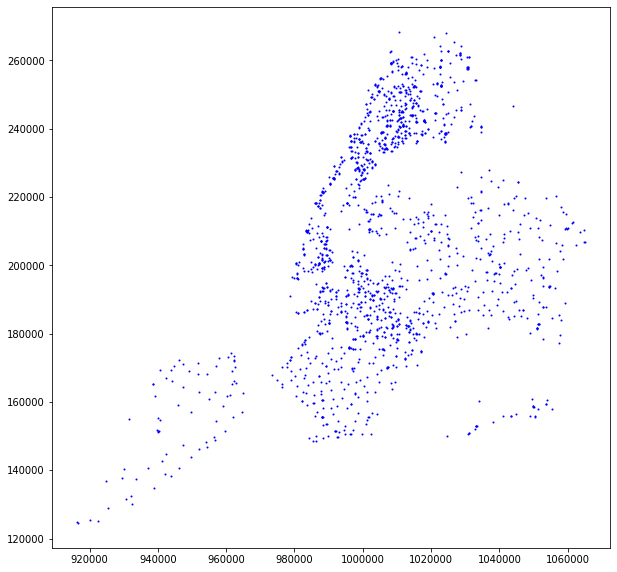

In [170]:
schools.plot(figsize = (10,10), markersize = 1, color = 'blue');

## Getting the subway information

Read the subway entract shapefile into a geopandas geodataframe

In [24]:
fp = r"https://data.cityofnewyork.us/api/geospatial/drex-xx56?method=export&format=Shapefile"
subway = gpd.read_file(fp)

In [27]:
subway.crs

{'init': 'epsg:4326'}

In [28]:
subway = subway.to_crs({'init': 'epsg:2263'})

In [35]:
subway.head()

,line,name,objectid,url,geometry
0,2-5,Birchall Ave & Sagamore St at NW corner,1734.0,http://web.mta.info/nyct/service/,POINT (1020670.668616476 248679.9905504963)
1,2-5,Birchall Ave & Sagamore St at NE corner,1735.0,http://web.mta.info/nyct/service/,POINT (1020710.253511059 248665.112299423)
2,2-5,Morris Park Ave & 180th St at NW corner,1736.0,http://web.mta.info/nyct/service/,POINT (1019251.986414479 245782.8697043241)
3,2-5,Morris Park Ave & 180th St at NW corner,1737.0,http://web.mta.info/nyct/service/,POINT (1019419.817771734 245866.9102186682)
4,2-5,Boston Rd & 178th St at SW corner,1738.0,http://web.mta.info/nyct/service/,POINT (1017557.721758398 245631.8322767556)


In [91]:
subway = subway.reset_index()

In [131]:
subway['index'] = subway.index

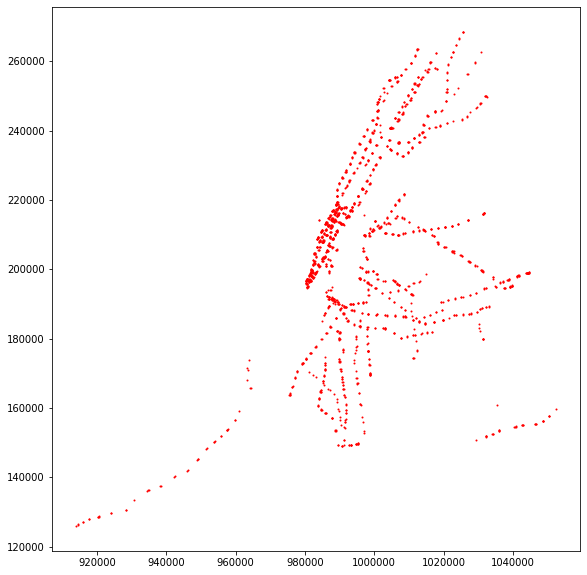

In [168]:
subway.plot(figsize = (10,10), markersize = 1, color = 'red');

## Adding these points into the street network

In [55]:
fp = r"../intermediate_data/nyclion_19b/"
lion_graph = nx.read_shp(fp+"nyclion_19b.shp", simplify = True, geom_attrs = True, strict = True)

In [56]:
fp = r"../intermediate_data/nyclion_19b/"
nx.write_shp(lion_graph, fp)

In [57]:
fp = r"../intermediate_data/nyclion_19b/"
# load as GeoDataFrame
nodes = gpd.read_file(fp+'nodes.shp')
edges = gpd.read_file(fp+'edges.shp')

In [63]:
nodes.crs = {'init': 'epsg:2263'}
edges.crs = {'init': 'epsg:2263'}

Create a point geopandas dataframe of these points.

In [43]:
points_to_add = gpd.GeoDataFrame(subway[['geometry']].append(schools[['geometry']], sort = False), crs = {'init': 'epsg:2263'})

In [58]:
points_to_add = points_to_add.reset_index()

In [59]:
points_to_add['key'] = points_to_add.index

This AWESOME function `connect_poi()` is adapted from [Yuwen Chang](https://github.com/ywnch/toolbox)

This is slightly modified from Yuwen's version.

In [81]:
def connect_poi(pois, nodes, edges, key_col=None, path=None, threshold=600, knn=5):
    """Connect and integrate a set of POIs into an existing road network.
    Given a road network in the form of two GeoDataFrames: nodes and edges,
    link each POI to the nearest edge (road segment) based on its projection
    point (PP) and generate a new integrated road network including the POIs,
    the projected points, and the connection edge.
    Args:
        pois (GeoDataFrame): a gdf of POI (geom: Point)
        nodes (GeoDataFrame): a gdf of road network nodes (geom: Point)
        edges (GeoDataFrame): a gdf of road network edges (geom: LineString)
        key_col (str): a unique key column of pois should be provided,
                       e.g., 'index', 'osmid', 'poi_number', etc.
                       Currently, this will be renamed into 'osmid' in the output.
                       [NOTE] For use in pandana, you may want to ensure this
                              column is numeric-only to avoid processing errors.
                              Preferably use unique integers (int or str) only,
                              and be aware not to intersect with the node key,
                              'osmid' if you use OSM data, in the nodes gdf.
        path (str): directory path to use for saving files (nodes and edges).
                      Outputs will NOT be saved if this arg is not specified.
        threshold (int): the max length of a POI connection edge, POIs with
                         connection edge beyond this length will be removed.
                         The unit is in meters as crs epsg is set to 3857 by
                         default during processing.
        knn (int): k nearest neighbors to query for the nearest edge.
                   Consider increasing this number up to 10 if the connection
                   output is slightly unreasonable. But higher knn number will
                   slow down the process.
    Returns:
        nodes (GeoDataFrame): the original gdf with POIs and PPs appended
        edges (GeoDataFrame): the original gdf with connection edges appended
                              and existing edges updated (if PPs are present)
    Note:
        1. Make sure all three input GeoDataFrames have defined crs attribute.
           Try something like `gdf.crs` or `gdf.crs = {'init': 'epsg:4326'}`.
           They will then be converted into epsg:3857 for processing.
    """

    ## STAGE 0: initialization
    # 0-1: helper functions
    def find_kne(point, lines):
        dists = np.array(list(map(lambda l: l.distance(point), lines)))
        kne_pos = dists.argsort()[0]
        kne = lines.iloc[[kne_pos]]
        kne_idx = kne.index[0]
        return kne_idx, kne.values[0]

    def get_pp(point, line):
        """Get the projected point (pp) of 'point' on 'line'."""
        # project new Point to be interpolated
        pp = line.interpolate(line.project(point))  # PP as a Point
        return pp

    def split_line(line, pps):
        """Split 'line' by all intersecting 'pps' (as multipoint).
        Returns:
            new_lines (list): a list of all line segments after the split
        """
        # IMPORTANT FIX for ensuring intersection between splitters and the line
        # but no need for updating edges_meter manually because the old lines will be
        # replaced anyway
        line = snap(line, pps, 1e-8)  # slow?

        try:
            new_lines = list(split(line, pps))  # split into segments
            return new_lines
        except TypeError as e:
            print('Error when splitting line: {}\n{}\n{}\n'.format(e, line, pps))
            return []

    def update_nodes(nodes, new_points, ptype):
        """Update nodes with a list (pp) or a GeoDataFrame (poi) of new_points.
        
        Args:
            ptype: type of Point list to append, 'pp' or 'poi'
        """
        # create gdf of new nodes (projected PAPs)
        if ptype == 'pp':
            new_nodes = gpd.GeoDataFrame(new_points, columns=['geometry'],
                                         crs={'init': 'epsg:2263'})
            n = len(new_nodes)
            new_nodes['highway'] = node_highway_pp
            new_nodes['osmid'] = [str(osmid_prefix + i) for i in range(n)]

        # create gdf of new nodes (original POIs)
        elif ptype == 'poi':
            new_nodes = new_points[['geometry', key_col]]
            new_nodes.columns = ['geometry', 'osmid']
            new_nodes['highway'] = node_highway_poi
            new_nodes['osmid'].astype(str, inplace=True)

        else:
            print("Unknown ptype when updating nodes.")

        # merge new nodes (it is safe to ignore the index for nodes)
        gdfs = [nodes, new_nodes]
        nodes = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True, sort=False),
                                 crs=gdfs[0].crs)

        return nodes, new_nodes  # all nodes, newly added nodes only

    def update_edges(edges, new_lines, replace):
        """
        Update edge info by adding new_lines; or,
        replace existing ones with new_lines (n-split segments).
        Args:
            replace: treat new_lines (flat list) as newly added edges if False,
                     else replace existing edges with new_lines (often a nested list)
        
        Note:
            kne_idx refers to 'fid in Rtree'/'label'/'loc', not positional iloc
        """
        # for interpolation (split by pp): replicate old line
        if replace:
            # create a flattened gdf with all line segs and corresponding kne_idx
            kne_idxs = list(line_pps_dict.keys())
            lens = [len(item) for item in new_lines]
            new_lines_gdf = gpd.GeoDataFrame(
                {'kne_idx': np.repeat(kne_idxs, lens),
                 'geometry': list(itertools.chain.from_iterable(new_lines))})
            # merge to inherit the data of the replaced line
            cols = list(edges.columns)
            cols.remove('geometry')  # don't include the old geometry
            new_edges = new_lines_gdf.merge(edges[cols], how='left',
                                            left_on='kne_idx', right_index=True)
            new_edges.drop('kne_idx', axis=1, inplace=True)
            new_lines = new_edges['geometry']  # now a flatten list
        # for connection (to external poi): append new lines
        else:
            new_edges = gpd.GeoDataFrame(pois[[key_col]], geometry=new_lines,
                                         columns=[key_col, 'geometry'])
            new_edges['oneway'] = False
            new_edges['highway'] = edge_highway

        # update features (a bit slow)
        new_edges['length'] = [l.length for l in new_lines]
        new_edges['from'] = new_edges['geometry'].map(
            lambda x: nodes_id_dict.get(list(x.coords)[0], 'None'))
        new_edges['to'] = new_edges['geometry'].map(
            lambda x: nodes_id_dict.get(list(x.coords)[-1], 'None'))
        new_edges['osmid'] = ['_'.join(s) for s in zip(new_edges['from'],
                                                       new_edges['to'])]

        # remember to reindex to prevent duplication when concat
        start = edges.index[-1] + 1
        stop = start + len(new_edges)
        new_edges.index = range(start, stop)

        # for interpolation: remove existing edges
        if replace:
            edges = edges.drop(kne_idxs, axis=0)
        # for connection: filter invalid links
        else:
            valid_pos = np.where(new_edges['length'] <= threshold)[0]
            n = len(new_edges)
            n_fault = n - len(valid_pos)
            f_pct = n_fault / n * 100
            print("Remove faulty projections: {}/{} ({:.2f}%)".format(n_fault,
                                                                      n,
                                                                      f_pct))
            new_edges = new_edges.iloc[valid_pos]  # use 'iloc' here

        # merge new edges
        dfs = [edges, new_edges]
        edges = gpd.GeoDataFrame(pd.concat(dfs, ignore_index=False, sort=False),
                                 crs=dfs[0].crs)

        # all edges, newly added edges only
        return edges, new_edges

    # 0-2: configurations
    # set poi arguments
    node_highway_pp = 'projected_pap'  # POI Access Point
    node_highway_poi = 'poi'
    edge_highway = 'projected_footway'
    osmid_prefix = 9990000000

    # convert CRS
    pois_meter = pois.to_crs(epsg=2263)
    nodes_meter = nodes.to_crs(epsg=2263)
    edges_meter = edges.to_crs(epsg=2263)

    # build rtree
    print("Building rtree...")
    Rtree = rtree.index.Index()
    [Rtree.insert(fid, geom.bounds) for fid, geom in
     edges_meter['geometry'].iteritems()];

    ## STAGE 1: interpolation
    # 1-1: update external nodes (pois)
    print("Updating external nodes...")
    nodes_meter, _ = update_nodes(nodes_meter, pois_meter, ptype='poi')

    # 1-2: update internal nodes (interpolated pps)
    # locate nearest edge (kne) and projected point (pp)
    print("Projecting POIs to the network...")
    pois_meter['near_idx'] = [list(Rtree.nearest(point.bounds, knn)) for point in
                              pois_meter['geometry']]  # slow
    pois_meter['near_lines'] = [edges_meter['geometry'][near_idx] for near_idx in
                                pois_meter['near_idx']]  # very slow
    pois_meter['kne_idx'], knes = zip(
        *[find_kne(point, near_lines) for point, near_lines in
          zip(pois_meter['geometry'], pois_meter['near_lines'])])  # slow
    pois_meter['pp'] = [get_pp(point, kne) for point, kne in
                        zip(pois_meter['geometry'], knes)]

    # update nodes
    print("Updating internal nodes...")
    nodes_meter, _ = update_nodes(nodes_meter, list(pois_meter['pp']),
                                  ptype='pp')
    nodes_coord = nodes_meter['geometry'].map(lambda x: x.coords[0])
    nodes_id_dict = dict(zip(nodes_coord, nodes_meter['osmid'].astype('str')))

    # 1-3: update internal edges (split line segments)
    print("Updating internal edges...")
    # split
    line_pps_dict = {k: MultiPoint(list(v)) for k, v in
                     pois_meter.groupby(['kne_idx'])['pp']}
    new_lines = [split_line(edges_meter['geometry'][idx], pps) for idx, pps in
                 line_pps_dict.items()]  # bit slow
    edges_meter, _ = update_edges(edges_meter, new_lines, replace=True)

    ## STAGE 2: connection
    # 2-1: update external edges (projected footways connected to pois)
    # establish new_edges
    print("Updating external links...")
    pps_gdf = nodes_meter[nodes_meter['highway'] == node_highway_pp]
    new_lines = [LineString([p1, p2]) for p1, p2 in
                 zip(pois_meter['geometry'], pps_gdf['geometry'])]
    edges_meter, _ = update_edges(edges_meter, new_lines, replace=False)

    ## STAGE 3: output
    # convert CRS
    nodes = nodes_meter.to_crs(epsg=2263)
    edges = edges_meter.to_crs(epsg=2263)

    # preprocess for pandana
    nodes.index = nodes['osmid']  # IMPORTANT
    nodes['x'] = [p.x for p in nodes['geometry']]
    nodes['y'] = [p.y for p in nodes['geometry']]

    # edges.reset_index(drop=True, inplace=True)
    edges['weight'] = edges['geometry'].length
    edges['weight'] = edges['weight'].astype(float)

    # report issues
    # - examine key duplication
    if len(nodes_meter) != len(nodes_id_dict):
        print("NOTE: duplication in node coordinates keys")
        print("Nodes count:", len(nodes_meter))
        print("Node coordinates key count:", len(nodes_id_dict))
    # - examine missing nodes
    print("Missing 'from' nodes:", len(edges[edges['from'] == 'None']))
    print("Missing 'to' nodes:", len(edges[edges['to'] == 'None']))

    # save and return
    if path:
        nodes.to_file(path+'/new_nodes.shp')
        edges[['geometry','weight']].to_file(path+'/new_edges.shp')
        print("new_nodes.shp and new_edges.shp are written into {}".format(path))

    return nodes, edges

In [82]:
fp = r"../intermediate_data/nyclion_19b/"
new_nodes, new_edges =  connect_poi(points_to_add, nodes, edges, key_col='key', path=fp)

Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 2/3637 (0.05%)
NOTE: duplication in node coordinates keys
Nodes count: 110931
Node coordinates key count: 110868
Missing 'from' nodes: 0
Missing 'to' nodes: 0
new_nodes.shp and new_edges.shp are written into ../intermediate_data/nyclion_19b/


## Reading in the modified street network

In [83]:
shp_file = r"../intermediate_data/nyclion_19b/new_edges.shp"
lion_gdf = gpd.read_file(shp_file)

In [84]:
shp_file = r"../intermediate_data/nyclion_19b/new_edges.shp"
lion_graph = nx.read_shp(shp_file, simplify = True, geom_attrs = True, strict = True)

## Convert to undirected graph

And create a nodes dataframe from graph

In [86]:
G = lion_graph.to_undirected()
G = nx.convert_node_labels_to_integers(G, first_label = 0, label_attribute='pos')
pos = nx.get_node_attributes(G, 'pos')

In [87]:
node_df = pd.DataFrame(pos.items(), columns=['node_id', 'geometry'])
node_df['geometry'] = node_df['geometry'].apply(Point)
node_gdf = gpd.GeoDataFrame(node_df, geometry='geometry')
node_gdf.crs = {'init': 'epsg:2263'}

## Locating the nodes for each location

We use cDKTree to locate the nodes of the school and subways.

In [96]:
# Create the tree 
#coord_array = np.array(list(zip(geodataframe.geometry.x, geodataframe.geometry.y)) )
#tree = cKDTree(coord_array)

def ckdnearest2(point_gemo, tree, kneighbors):
    """
    This function read in a coordinate xy position, and a declared cdktree.
    The aim is to find the closest point to the coordinate xy position from the tree 
    The function will return the distance between the closest point to the coordinate and the ID of that closest point.
    """
    coordinate_xy = (point_gemo.x,point_gemo.y)
    dist, idx = tree.query(coordinate_xy,k=kneighbors)
    if kneighbors == 1:
        dist = int(dist)
        idx = int(idx)    
    return dist, idx

In [103]:
coord_array = np.array(list(zip(node_gdf.geometry.x, node_gdf.geometry.y)) )
node_tree = cKDTree(coord_array)

In [106]:
subway[['distance_to_node','node_id']] = subway.apply(lambda row: ckdnearest2( row['geometry'], node_tree, 1),
                                                     axis = 1,
                                                     result_type = 'expand')

In [110]:
subway['distance_to_node'].value_counts()

0    1928
Name: distance_to_node, dtype: int64

In [111]:
subway.drop('distance_to_node', axis = 1, inplace = True)

In [105]:
schools[['distance_to_node','node_id']] = schools.apply(lambda row: ckdnearest2( row['geometry'], node_tree, 1),
                                                        axis = 1,
                                                        result_type = 'expand')

In [112]:
schools['distance_to_node'].value_counts()

0        1707
21949       1
11187       1
Name: distance_to_node, dtype: int64

There are two schools that are really far when they should be at a distance of zero from the nodes. Recall when I ran the `connect_poi()` function that it `Remove faulty projections: 2/3637 (0.05%)`.

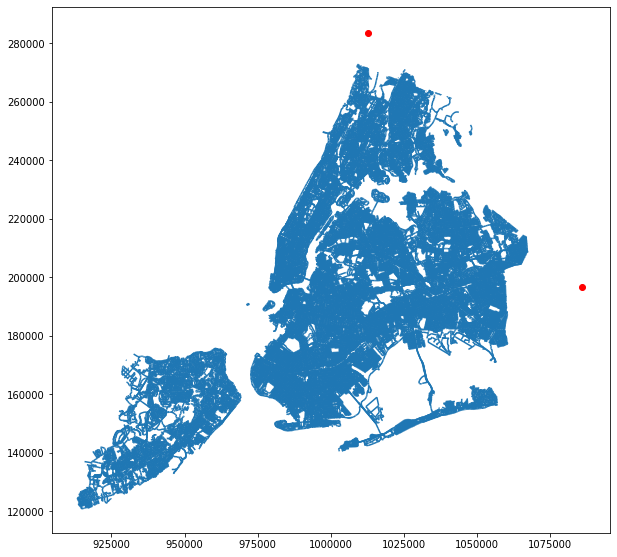

In [116]:
fig, ax = plt.subplots(figsize=(10, 10))

new_edges.plot(ax=ax)
schools.loc[schools['distance_to_node']>0].plot(ax=ax, color = 'red')

Remove schools that are not in NYC

In [118]:
schools = schools[schools['distance_to_node'] == 0]

In [129]:
schools.drop('distance_to_node', axis = 1, inplace = True)

## Finding the nearest 2 subway entrances

Now we want to find the closest 2 subway entrances to each school

Set up the tree for subway location

In [119]:
coord_array = np.array(list(zip(subway.geometry.x, subway.geometry.y)) )
subway_tree = cKDTree(coord_array)

In [124]:
schools[['distance_to_subway_nodes','subway_ids']] = schools.apply(lambda row: ckdnearest2( row['geometry'], subway_tree, 2),
                                                        axis = 1,
                                                        result_type = 'expand')

Parse out the subway_node_ids

In [125]:
schools['closest_subway_id1'], schools['closest_subway_id2'] = zip(*schools['subway_ids'])

In [130]:
schools.head()

,ATS_CODE,BORO,BORONUM,LOC_CODE,SCHOOLNAME,SCH_TYPE,MANAGED_BY,GEO_DISTRI,ADMIN_DIST,ADDRESS,...,PRIN_PH,FAX,GRADES,City,geometry,node_id,distance_to_subway_nodes,subway_ids,closest_subway_id1,closest_subway_id2
0,15K001,K,2.0,K001,P.S. 001 THE BERGEN,Elementary,1,15,15,309 47 STREET,...,718-567-7661,718-567-9771,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (980985.0541713729 175780.758994163),109165,"[574.0166423762518, 617.2474703341181]","[1744, 1746]",1744,1746
1,17K002,K,2.0,K002,M.S. 002,Junior High-Intermediate-Middle,1,17,17,655 PARKSIDE AVENUE,...,718-462-6992,718-284-7717,"06,07,08,SE",BROOKLYN,POINT (997785.1364296663 178431.910832498),109166,"[258.5002370023575, 442.8355620846949]","[1349, 749]",1349,749
2,21K095,K,2.0,K095,P.S. 095 THE GRAVESEND,K-8,1,21,21,345 VAN SICKLEN STREET,...,718-449-5050,718-449-3047,"PK,0K,01,02,03,04,05,06,07,08,SE",BROOKLYN,POINT (991224.9830063033 156323.3612131244),109167,"[431.5770408752747, 492.43651609913985]","[1522, 1591]",1522,1591
3,21K096,K,2.0,K096,I.S. 096 SETH LOW,Junior High-Intermediate-Middle,1,21,21,99 AVENUE P,...,718-236-1344,718-236-2397,"06,07,08,SE",BROOKLYN,POINT (988439.6813609767 160709.9926236183),109168,"[1366.7287949334989, 1549.5096241139383]","[443, 203]",443,203
4,21K097,K,2.0,K097,P.S. 97 THE HIGHLAWN,Elementary,1,21,21,1855 STILLWELL AVENUE,...,718-372-7393,718-372-3842,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (988205.0729096507 158329.5913366843),109169,"[1224.1544066200531, 1270.3197366749077]","[190, 189]",190,189


In [132]:
subway.head()

,index,line,name,objectid,url,geometry,node_id
0,0,2-5,Birchall Ave & Sagamore St at NW corner,1734.0,http://web.mta.info/nyct/service/,POINT (1020670.668616476 248679.9905504963),107248
1,1,2-5,Birchall Ave & Sagamore St at NE corner,1735.0,http://web.mta.info/nyct/service/,POINT (1020710.253511059 248665.112299423),107249
2,2,2-5,Morris Park Ave & 180th St at NW corner,1736.0,http://web.mta.info/nyct/service/,POINT (1019251.986414479 245782.8697043241),107250
3,3,2-5,Morris Park Ave & 180th St at NW corner,1737.0,http://web.mta.info/nyct/service/,POINT (1019419.817771734 245866.9102186682),107251
4,4,2-5,Boston Rd & 178th St at SW corner,1738.0,http://web.mta.info/nyct/service/,POINT (1017557.721758398 245631.8322767556),107252


Merging in the respective node_ids for the nearest subway locations

In [133]:
schools = schools.merge(subway[['index','node_id']], 
                        how = 'left', 
                        left_on = 'closest_subway_id1', 
                        right_on = 'index')

In [135]:
schools.drop('index', axis = 1, inplace = True)
schools.rename(columns={"node_id_y": "subway_node_id1"},inplace =True)

In [136]:
schools = schools.merge(subway[['index','node_id']], 
                        how = 'left', 
                        left_on = 'closest_subway_id2', 
                        right_on = 'index')

In [139]:
schools.drop('index', axis = 1, inplace = True)
schools.rename(columns={"node_id": "subway_node_id2"},inplace =True)

In [141]:
schools.rename(columns={"node_id_x": "node_id"},inplace =True)

In [143]:
def network_distance(graph, node_gdf, origin_node, target_node, weight_name):
    """"
    graph is the networkx graph
    node_gdf is the geodataframe of nodes. This will allow us to create the LineString.
    origin_node is the starting node to begin the network distance
    target_node is the end node to end the network distance
    weight is the distance measure

    We use the shortest_path function from networkx.
    Use the nodes on the shortest path and extract the coordinates from the node_gdf
    Use the geometry from the route_nodes to create the line string
    From the line string we will extract the length
    """    
    
    try:
        route = nx.shortest_path(G=graph, source=origin_node, target=target_node, weight = weight_name)
        route_nodes = node_gdf.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))
    except:
        route_line = LineString()
        
    route_line_dist = int(route_line.length)
    return route_line, route_line_dist

## Network distance

In [147]:
t0 = time.time()
schools[['route1_geom', 'route1_dist']] = schools.apply(
        lambda row: network_distance(G, node_gdf, row['node_id'], target_node = row['subway_node_id1'],weight_name = 'weight'), 
        axis = 1, 
        result_type = 'expand')

t1 = time.time()
time_difference = (((t1-t0)/60)/60)
print("It took {0} hours".format(time_difference))

It took 0.002573776576254103 hours


In [148]:
t0 = time.time()
schools[['route2_geom', 'route2_dist']] = schools.apply(
        lambda row: network_distance(G, node_gdf, row['node_id'], target_node = row['subway_node_id2'],weight_name = 'weight'), 
        axis = 1, 
        result_type = 'expand')

t1 = time.time()
time_difference = (((t1-t0)/60)/60)
print("It took {0} hours".format(time_difference))

It took 0.0028666459189520942 hours


Determine which route is shorter between the two

In [149]:
schools.loc[(schools['route1_dist'] <= schools['route2_dist']), 'shortest_network_distance'] = schools['route1_dist'] 
schools.loc[(schools['route1_dist'] > schools['route2_dist']) , 'shortest_network_distance'] = schools['route2_dist']

In [151]:
schools.loc[(schools['route1_dist'] <= schools['route2_dist']), 'shortest_network_geom'] = schools['route1_geom'] 
schools.loc[(schools['route1_dist'] > schools['route2_dist']), 'shortest_network_geom'] = schools['route2_geom']

## Plot the schools, subway and routes

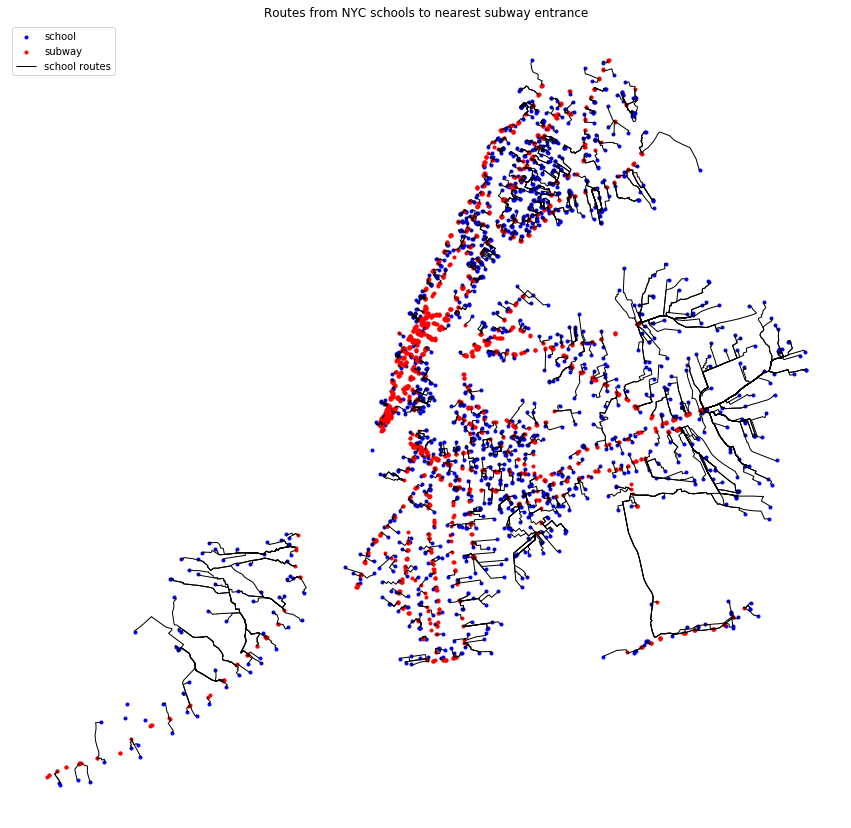

In [167]:
fig, ax = plt.subplots(figsize=(15, 15))

schools.plot(ax=ax, color = 'blue', markersize = 9, label = 'school')
subway.plot(ax=ax, color = 'red', markersize = 9, label = 'subway')
schools = schools.set_geometry('shortest_network_geom')
schools.plot(ax=ax, color = 'black', linewidth=1, label = 'school routes')
#Set default back
schools = schools.set_geometry('geometry')

plt.title("Routes from NYC schools to nearest subway entrance")
plt.legend(loc='upper left')

ax.set_axis_off()
plt.show();